In [1]:
from main import *
%matplotlib widget


def get_current_directory():
    try:
        
        directory = os.path.dirname(os.path.abspath(__file__))

    except:
        
        ip = IPython.get_ipython()
        directory = None
        if '__vsc_ipynb_file__' in ip.user_ns:
            directory = os.path.dirname(ip.user_ns['__vsc_ipynb_file__'])
        
    return directory 


def salvar(a):
    
    script_dir = get_current_directory()
    
    dados_dir = os.path.join(script_dir, 'dados')
    
    os.makedirs(dados_dir, exist_ok=True)
    
    file_path = os.path.join(dados_dir, f'{a}.pickle')
    
    with open(file_path, 'wb') as f:
        pickle.dump(eval(a), f)

def abrir(a):
    
    script_dir = get_current_directory()
    
    file_path = os.path.join(script_dir, 'dados', f'{a}.pickle')
    
    with open(file_path, 'rb') as f:
        return pickle.load(f)
    
def salvar_obj(obj, filename):
    script_dir = get_current_directory()
    dados_dir = os.path.join(script_dir, 'dados')
    os.makedirs(dados_dir, exist_ok=True)
    
    file_path = os.path.join(dados_dir, f'{filename}.pickle')
    
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)

In [2]:
hamiltoniano = es_problem.second_q_ops()[0]

mapper.map(hamiltoniano)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.8567854 +0.j,  0.13716573+0.j, -0.13036292+0.j,  0.13716573+0.j,
 -0.13036292+0.j,  0.10622904+0.j,  0.15660062+0.j,  0.15542669+0.j,
  0.04919765+0.j,  0.04919765+0.j,  0.04919765+0.j,  0.04919765+0.j,
  0.15542669+0.j,  0.16326769+0.j,  0.10622904+0.j])

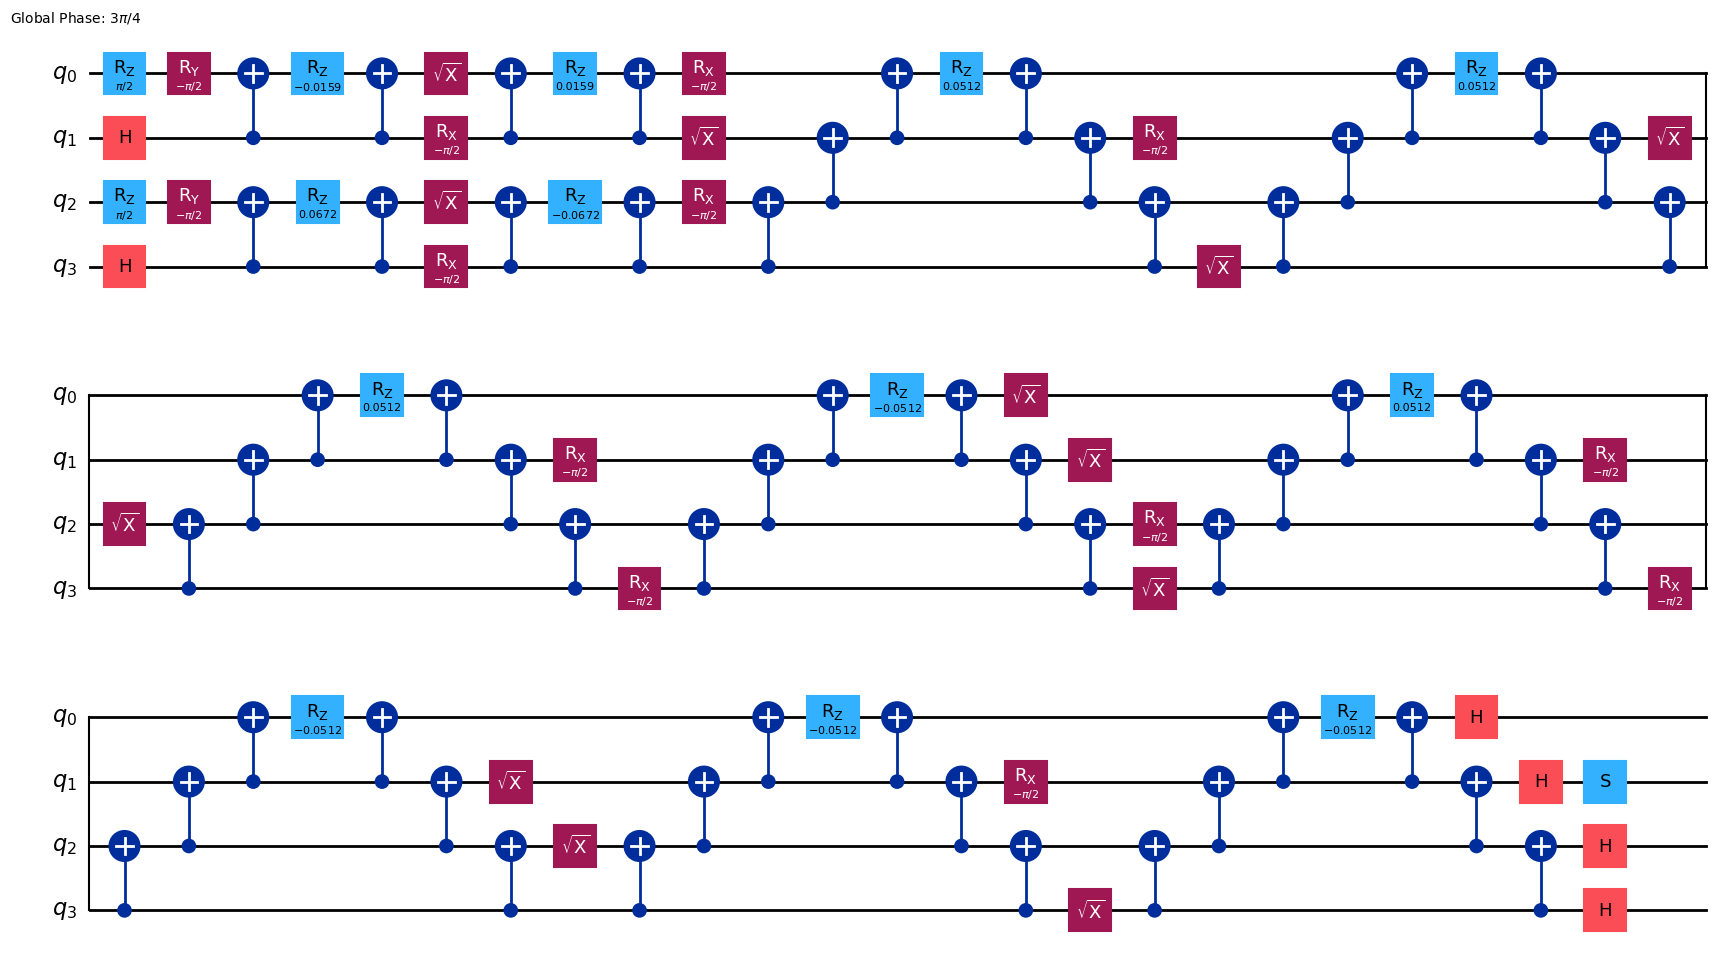

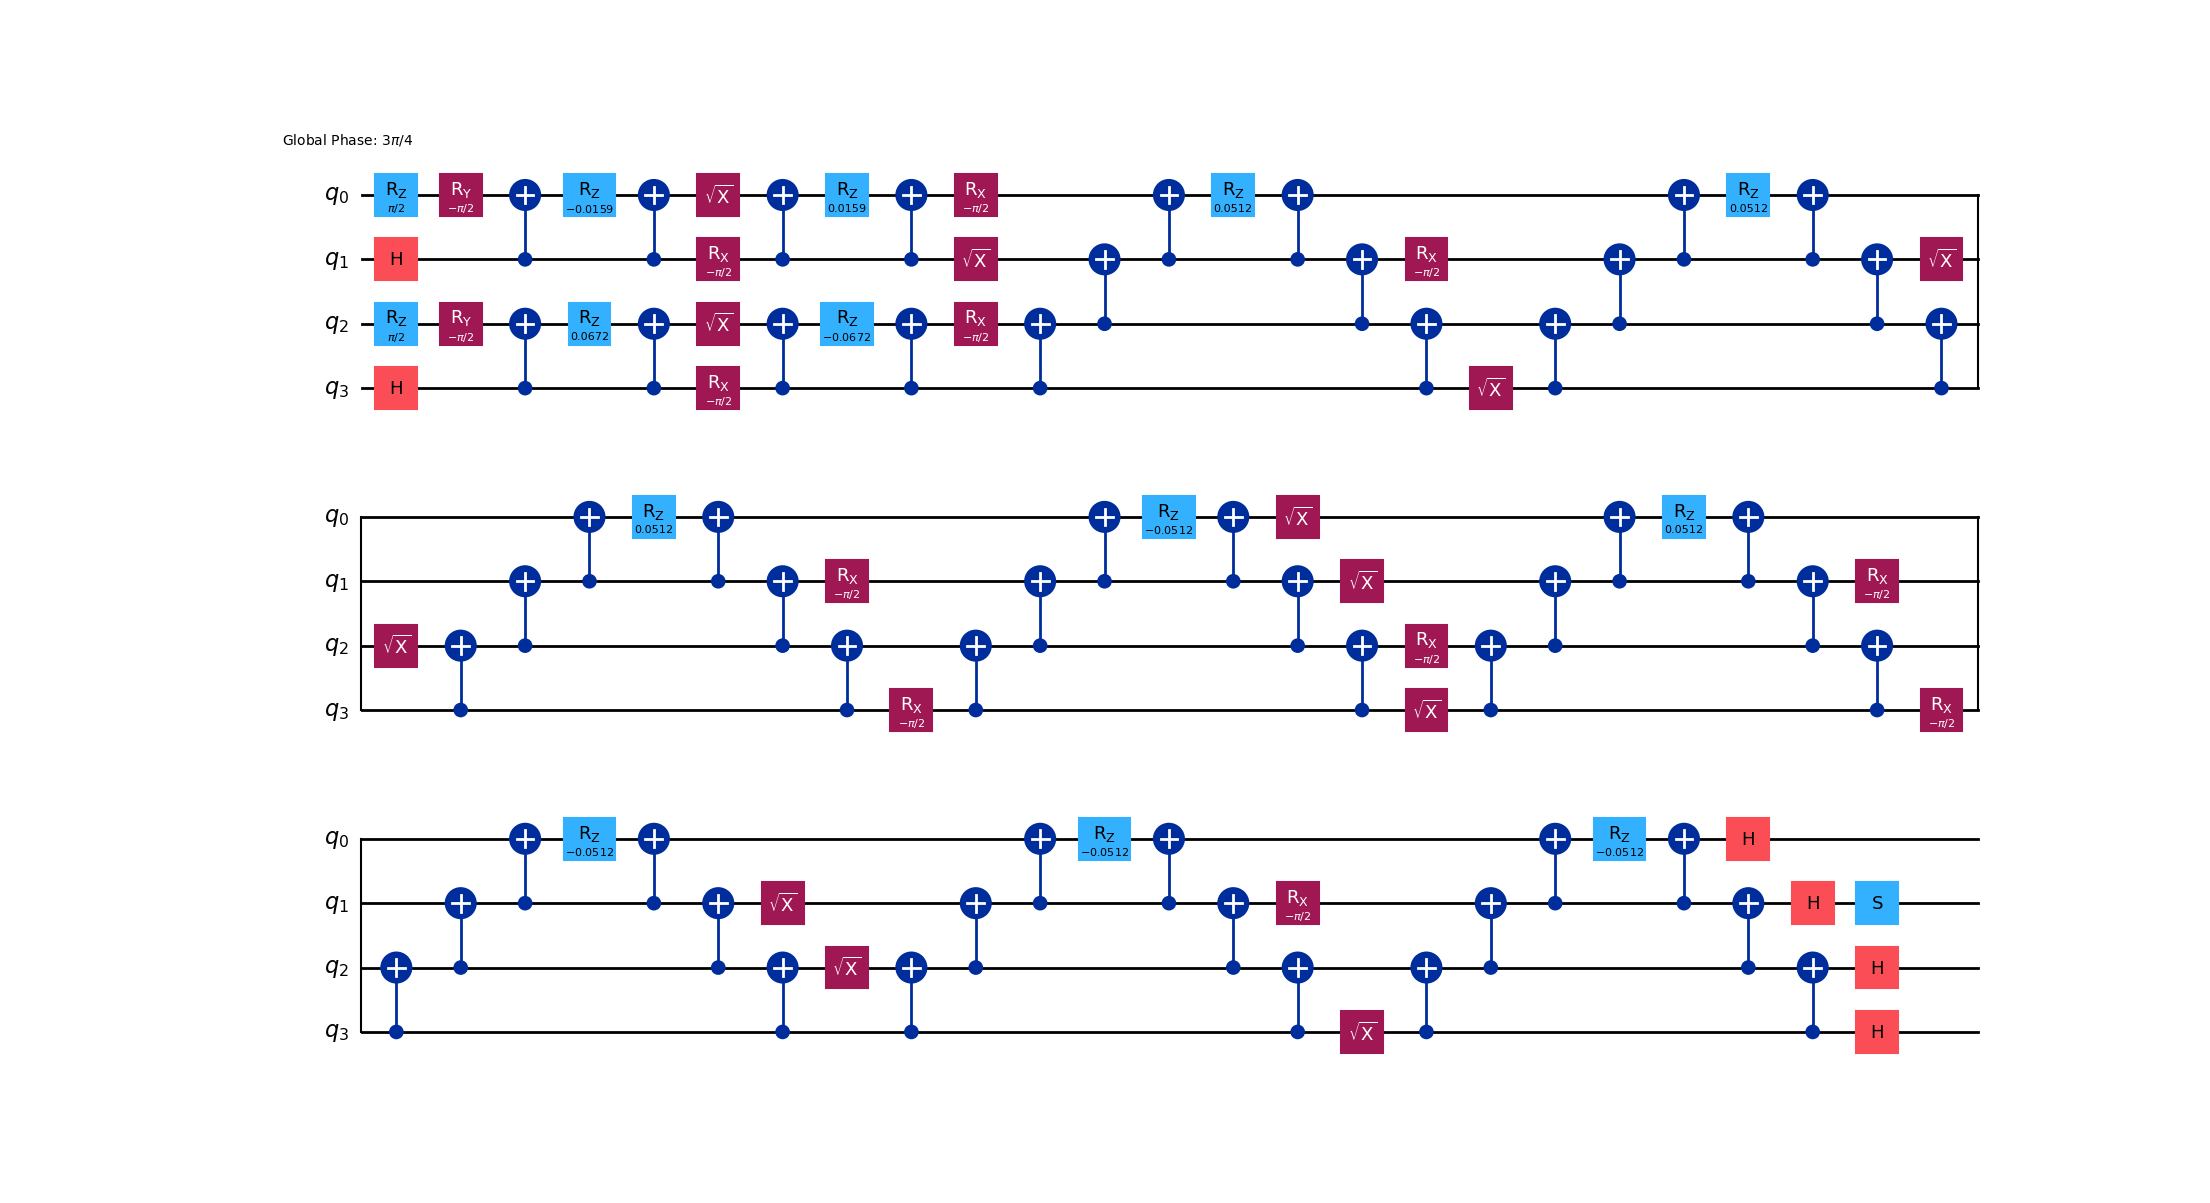

In [3]:
circuito_sv1 = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), sv1)

circuito_sv1.draw(output='mpl')

In [4]:
def run_estimator_aws(circuit, driver, backend, shots = 1000, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
      
   #estimator = EstimatorV2(backend = backend, options = {"shots" : shots})
   estimator = EstimatorV2(backend = backend)
   estimator.options.default_shots = shots
   
   #job = estimator.run(circuit, mapper.map(hamiltoniano))
   job = estimator.run([(circuit, mapper.map(hamiltoniano), [])])
   
   return job



In [5]:
circuito_local = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), local_simulator)


j_local_simulator_Estimator_circuito = run_estimator_aws(circuito_local, es_problem, local_simulator, 2000)

/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'default_shots': 2000} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [6]:
j_sv1_Estimator_circuito = run_estimator_aws(circuito_sv1, es_problem, sv1, 2000)

TypeError: cannot pickle '_contextvars.Context' object

In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
import numpy as np

def valor_esperado(circuito, observable, backend, shots=1024):

    valor_esperado_0 = 0

    for pauli_, coeff in zip(observable.paulis, observable.coeffs):
        
        temp_circuito = circuito.copy()

        for qubit_index, pauli in enumerate(pauli_.to_label()):

            if pauli == 'X':

                temp_circuito.h(qubit_index)  

            elif pauli == 'Y':

                temp_circuito.sdg(qubit_index)
                temp_circuito.h(qubit_index)
        
        temp_circuito.measure_all()       
        
        job = backend.run(transpile(temp_circuito, backend), shots=shots)
        task_id = job.job_id()
        retrieved_job = backend.retrieve_job(task_id=task_id)
        counts = retrieved_job.result().get_counts()
        
        temp_expectation = 0
        total_counts = sum(counts.values())
        
        for resultado, count in counts.items():
        
            resultado = resultado[::-1]
        
            paridade = (-1) ** sum(int(resultado[qubit_index]) for qubit_index, pauli in enumerate(pauli_.to_label()) if pauli != 'I')
            temp_expectation += paridade * (count / total_counts)
        
        valor_esperado_0 += coeff.real * temp_expectation  
    
    return valor_esperado_0


In [8]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_aer import Aer

qc = QuantumCircuit(1)
qc.h(0)  

observable = SparsePauliOp(['Z', 'X'], coeffs=[1.0, 0.5])

refined_value = valor_esperado(qc, observable, sv1, shots=1024)

estimator = Estimator()
estimator_value = estimator.run(circuits=[qc], observables=[observable]).result().values[0]

print(f"Refined Custom Estimator Value: {refined_value}")
print(f"EstimatorV2 Value: {estimator_value}")


/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:457: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(


Refined Custom Estimator Value: 0.529296875
EstimatorV2 Value: 0.4999999999999999


In [9]:
expectation_value_sv1 = valor_esperado(circuito_sv1, mapper.map(es_problem.second_q_ops()[0]), sv1, shots=1024)

expectation_value_Aer_local = run_estimator_aer(circuito_sv1, es_problem)

print(f"Expectation value SV1: {expectation_value_sv1}\nExpectation value Aer local: {expectation_value_Aer_local}")

/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 2.356194490192345 will not be included in Braket circuit
  warnings.warn(
/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 0.7853981633974483 will not be included in Braket circuit
  warnings.warn(
/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(


Expectation value SV1: -0.6530732476314198
Expectation value Aer local: -1.627130058686923


In [10]:
circuito_sv1.data

[CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), qubits=(Qubit(QuantumRegister(4, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[-1.5707963267948966]), qubits=(Qubit(QuantumRegister(4, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 1),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 0)), clbits=()), CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-0.015893171316909125]), qubits=(Qubit(QuantumRegister(4, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'

In [11]:
import numpy 
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_aer import Aer

X = numpy.array([[0, 1], [1, 0]])
Z = numpy.array([[1, 0], [0, -1]])

rotation = X @ Z

rotation_gate = Operator(rotation)

print(rotation)


[[ 0 -1]
 [ 1  0]]


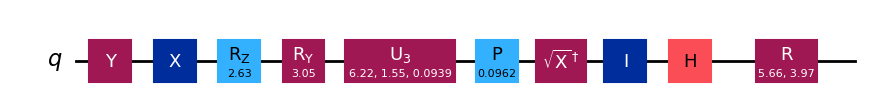

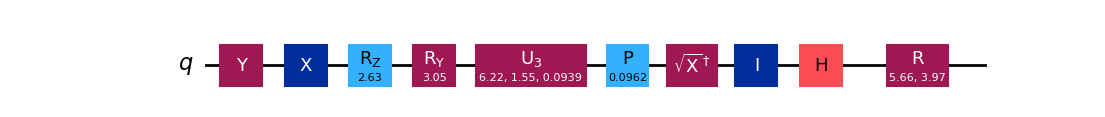

In [12]:
from qiskit.circuit.random import random_circuit


qc = random_circuit(1, 10, max_operands=3, seed=4212124123515)

qc_temp = qc.copy()

qc_temp.unitary(rotation_gate, [0], label='rotation')

qc.draw(output='mpl')



In [13]:
observable = SparsePauliOp(['X'], coeffs=[1.0])

temp_circuito = qc_temp.copy()

temp_circuito.measure_all()       

job = sv1.run(transpile(temp_circuito, sv1), shots=1000)
task_id = job.job_id()
retrieved_job = sv1.retrieve_job(task_id=task_id)
counts = retrieved_job.result().get_counts()

print(counts)

/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 3.975111772472071 will not be included in Braket circuit
  warnings.warn(


{'1': 706, '0': 294}


In [14]:
expectation_value = 0

for resultado, count in counts.items():

    expectation_value += (-1) ** int(resultado) * (count / 1000)
    
print(expectation_value)

-0.412


In [15]:
refined_value = valor_esperado(qc, observable, sv1, shots=1024)

estimator_value = estimator.run(circuits=[qc], observables=[SparsePauliOp(['X'], coeffs=[1.0])]).result().values[0]

print(f"Refined Custom Estimator Value: {refined_value}")
print(f"EstimatorV2 Value: {estimator_value}")

/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 5.545908099266967 will not be included in Braket circuit
  warnings.warn(


Refined Custom Estimator Value: -0.021484375
EstimatorV2 Value: -0.05817326110807822


/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 4.957029219688306 will not be included in Braket circuit
  warnings.warn(
/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 0.8244359343071066 will not be included in Braket circuit
  warnings.warn(
/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 4.259786589254478 will not be included in Braket circuit
  warnings.warn(
/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase 

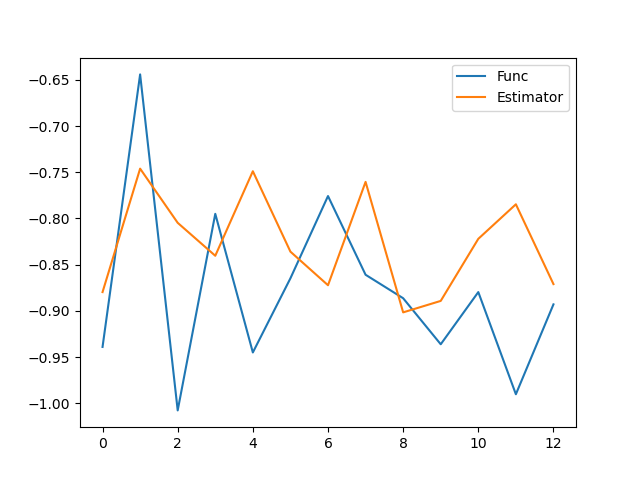

In [17]:
from qiskit.circuit.random import random_circuit

metodo_nara = []
metodo_func = []
metodo_estimator = []


for a in range(13):
    
    qc = random_circuit(4, 90, max_operands=3, seed=np.random.randint(0, 100000))
        
    observable = operator = SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'XXXX', 'XXXX', 'IIXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.8567854 +0.j,  0.13716573+0.j, -0.13036292+0.j,  0.10622904+0.j,
  0.13716573+0.j,  0.15660062+0.j, -0.13036292+0.j,  0.15542669+0.j,
  0.04919765+0.j,  0.04919765+0.j,  0.04919765+0.j,  0.04919765+0.j,
  0.15542669+0.j,  0.16326769+0.j,  0.10622904+0.j])
        
    refined_value = valor_esperado(qc, observable, sv1, shots=1024)

    estimator_value = estimator.run(circuits=[qc], observables=observable).result().values[0]

    metodo_func.append(refined_value)
    metodo_estimator.append(estimator_value)
    
plt.figure()
plt.plot(metodo_func, label='Func')
plt.plot(metodo_estimator, label='Estimator')
plt.legend()

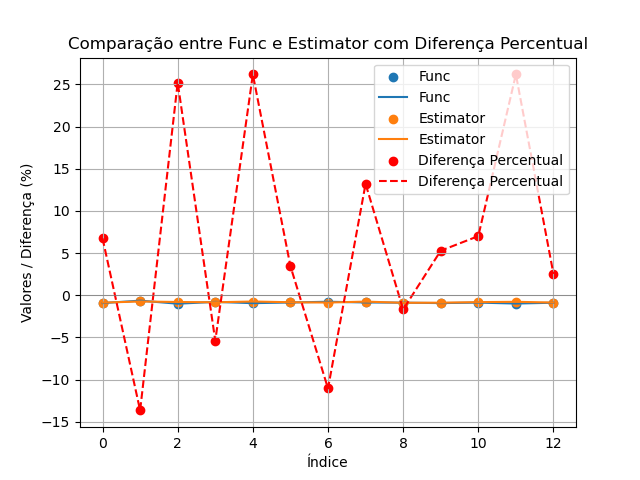

In [ ]:
plt.figure()
plt.scatter(range(13), metodo_func, label='Func')
plt.plot(metodo_func, label='Func')
plt.scatter(range(13), metodo_estimator, label='Estimator')
plt.plot(metodo_estimator, label='Estimator')
diferenca_percentual = [(mf - me)/me * 100 for mf, me in zip(metodo_func, metodo_estimator)]
plt.scatter(range(13), diferenca_percentual, label='Diferença Percentual', color='red')
plt.plot(diferenca_percentual, label='Diferença Percentual', color='red', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
plt.legend()
plt.title('Comparação entre Func e Estimator com Diferença Percentual')
plt.xlabel('Índice')
plt.ylabel('Valores / Diferença (%)')
plt.grid(True)
plt.show()

In [86]:
expectation_value_sv1 = valor_esperado(circuito_sv1, mapper.map(es_problem.second_q_ops()[0]), sv1, shots=1024)

expectation_value_Aer_local = run_estimator_aer(circuito_sv1, es_problem)

print(f"Expectation value SV1: {expectation_value_sv1}\nExpectation value Aer local: {expectation_value_Aer_local}")

/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 2.356194490192345 will not be included in Braket circuit
  warnings.warn(
/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 0.7853981633974483 will not be included in Braket circuit
  warnings.warn(
/home/gabriel/miniconda/envs/aws_braket_updated_2/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:500: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(


Expectation value SV1: -0.6425831373342981
Expectation value Aer local: -1.6299163177775375


In [ ]:
operator = SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'XXXX', 'XXXX', 'IIXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.8567854 +0.j,  0.13716573+0.j, -0.13036292+0.j,  0.10622904+0.j,
  0.13716573+0.j,  0.15660062+0.j, -0.13036292+0.j,  0.15542669+0.j,
  0.04919765+0.j,  0.04919765+0.j,  0.04919765+0.j,  0.04919765+0.j,
  0.15542669+0.j,  0.16326769+0.j,  0.10622904+0.j])


for pauli_, coeff in zip(observable.paulis, observable.coeffs):
    
    print(pauli_, coeff)
    
    for qubit_index, pauli in enumerate(pauli_.to_label()):
      
      print(qubit_index, pauli)

IIII (-0.8567854+0j)
0 I
1 I
2 I
3 I
IIIZ (0.13716573+0j)
0 I
1 I
2 I
3 Z
IIZI (-0.13036292+0j)
0 I
1 I
2 Z
3 I
IIZZ (0.10622904+0j)
0 I
1 I
2 Z
3 Z
IZII (0.13716573+0j)
0 I
1 Z
2 I
3 I
IZIZ (0.15660062+0j)
0 I
1 Z
2 I
3 Z
ZIII (-0.13036292+0j)
0 Z
1 I
2 I
3 I
ZIIZ (0.15542669+0j)
0 Z
1 I
2 I
3 Z
YYYY (0.04919765+0j)
0 Y
1 Y
2 Y
3 Y
XXYY (0.04919765+0j)
0 X
1 X
2 Y
3 Y
YYXX (0.04919765+0j)
0 Y
1 Y
2 X
3 X
XXXX (0.04919765+0j)
0 X
1 X
2 X
3 X
IZZI (0.15542669+0j)
0 I
1 Z
2 Z
3 I
ZIZI (0.16326769+0j)
0 Z
1 I
2 Z
3 I
ZZII (0.10622904+0j)
0 Z
1 Z
2 I
3 I


In [99]:
dense_matrix = operator.to_matrix()

print("Matrix form of SparsePauliOp:")
print(dense_matrix.shape)
print(dense_matrix)

Matrix form of SparsePauliOp:
(16, 16)
[[-1.00000000e-08+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -1.11084417e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j -5.89121010e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00